In [1]:
import matplotlib.pyplot as plt
from data_setup import create_dataloaders
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from pathlib import Path
import torch
import torch_geometric
import networkx as nx
import numpy as np
from models import GCNClassifier, GATClassifier, GINConvClassifier, GINEConvClassifier, GraphConvClassifier
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import  ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix
from utils import new_metric_func, average_model_metrics, plot_average_metrics, loss_acc_auc_plots
import pickle

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/louis/Documents/personal_coding/graph_neural_networks/deep_chem_env_2/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
project_path = Path("/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/")
data_path = project_path / "data"
bace_path = data_path / "raw"
bace_models_path = project_path/ "models"

In [4]:
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df["Class"].value_counts()

0    822
1    691
Name: Class, dtype: int64

In [5]:
dataset, train_dataset, test_dataset, train_dataloader, test_dataloader = create_dataloaders(root_directory = "/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/data/",
                                                                batch_size = 32, shuffled_indices_path  = "/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/data/dataset_indices_list")

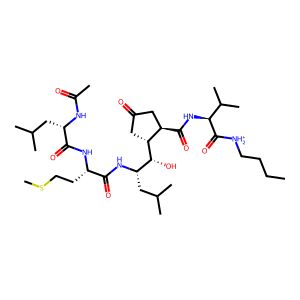

In [6]:
inhibitor = dataset[30]["smiles"]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

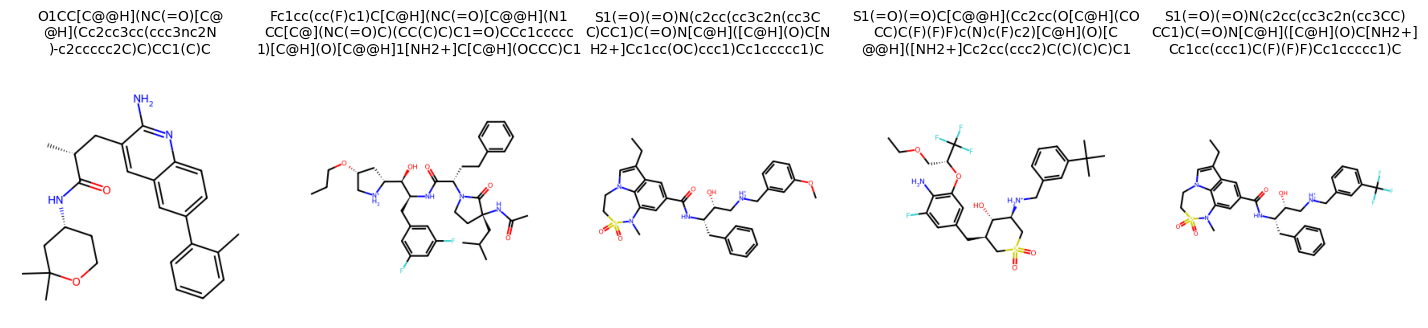

In [7]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
# mols = bace_df.sample(n=5, random_state=42)["mol"]
mols = dataset[:5]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols[i]["smiles"]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title, fontsize=10)

In [8]:
# Load a single graph

print(f"Number of nodes in graph is: {dataset[0].x.shape[0]}")
print(f"Number of features for each node is {dataset[0].num_features}")
print(f"Number of edges is {dataset[0].edge_index.shape[1]}")
print(f"Data object is {dataset[0]}\n")

Number of nodes in graph is: 32
Number of features for each node is 30
Number of edges is 70
Data object is Data(x=[32, 30], edge_index=[2, 70], edge_attr=[70, 11], Class=[1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', pic50=9.1549015)



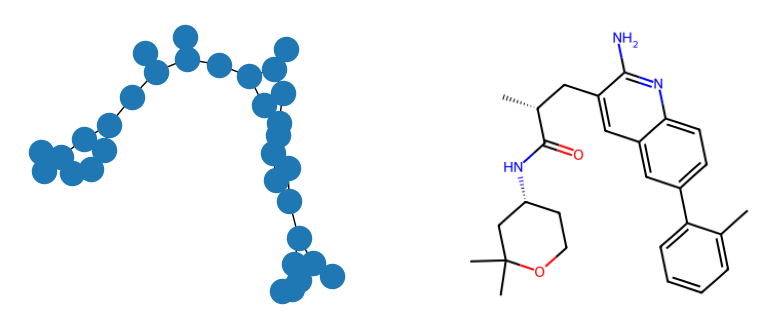

In [9]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (10,4))

g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [10]:
print(train_dataset.indices())
print(test_dataset.indices())

[812, 780, 1275, 897, 196, 1108, 845, 477, 1233, 1474, 581, 269, 1022, 967, 1031, 661, 1215, 1472, 150, 311, 281, 1509, 848, 1444, 84, 230, 571, 1296, 515, 1004, 190, 199, 511, 762, 642, 347, 971, 1005, 495, 1071, 252, 103, 36, 412, 994, 1312, 654, 777, 1121, 1494, 877, 1074, 1493, 1192, 530, 644, 1375, 1441, 711, 63, 746, 1339, 450, 1073, 1252, 1066, 299, 797, 23, 938, 429, 250, 741, 386, 1342, 734, 154, 1416, 336, 1044, 451, 172, 47, 1446, 513, 675, 828, 1331, 93, 794, 1129, 876, 912, 142, 374, 964, 659, 140, 194, 1295, 116, 706, 399, 528, 577, 690, 1450, 1196, 303, 175, 878, 1159, 817, 534, 976, 1290, 1177, 206, 1009, 233, 482, 197, 115, 339, 617, 808, 1512, 85, 977, 724, 899, 1245, 388, 953, 504, 109, 279, 929, 748, 1139, 468, 1425, 1206, 332, 923, 1455, 552, 1297, 1421, 1056, 280, 1113, 957, 851, 1255, 1382, 802, 662, 398, 1072, 312, 1321, 3, 310, 575, 137, 879, 637, 1440, 678, 158, 209, 781, 55, 186, 632, 960, 235, 1141, 663, 640, 1491, 1484, 593, 1214, 541, 728, 1033, 684, 826, 

In [11]:
# Load a random GCN model to try new_metric_func on 
bace_gcn_models_path =  bace_models_path / "gcn_models"
model_save_path = bace_gcn_models_path/"0_128_300_global_mean_pool.pth"

loaded_model = GCNClassifier(30, 128, 2, global_mean_pool)



if torch.cuda.is_available():
  loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

  loaded_model.eval()


Model parameters saved at epochs:
154
202
186
108
127


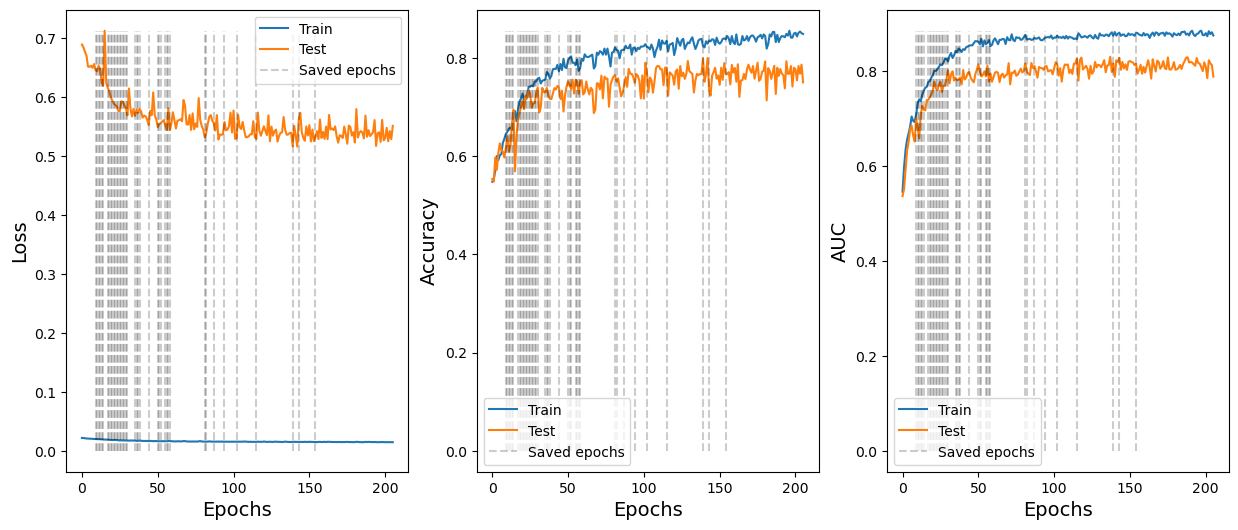

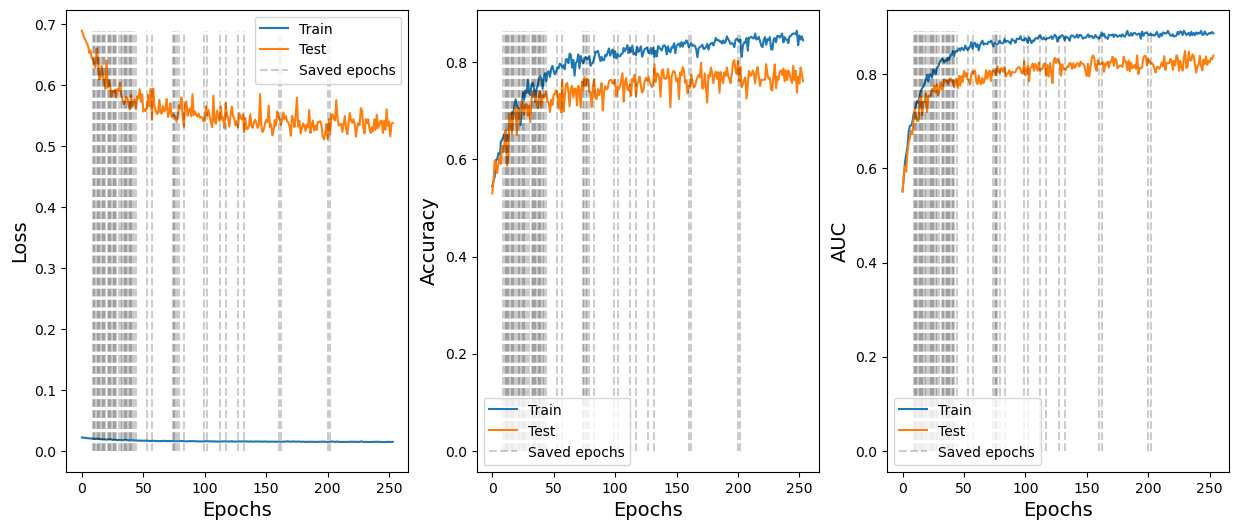

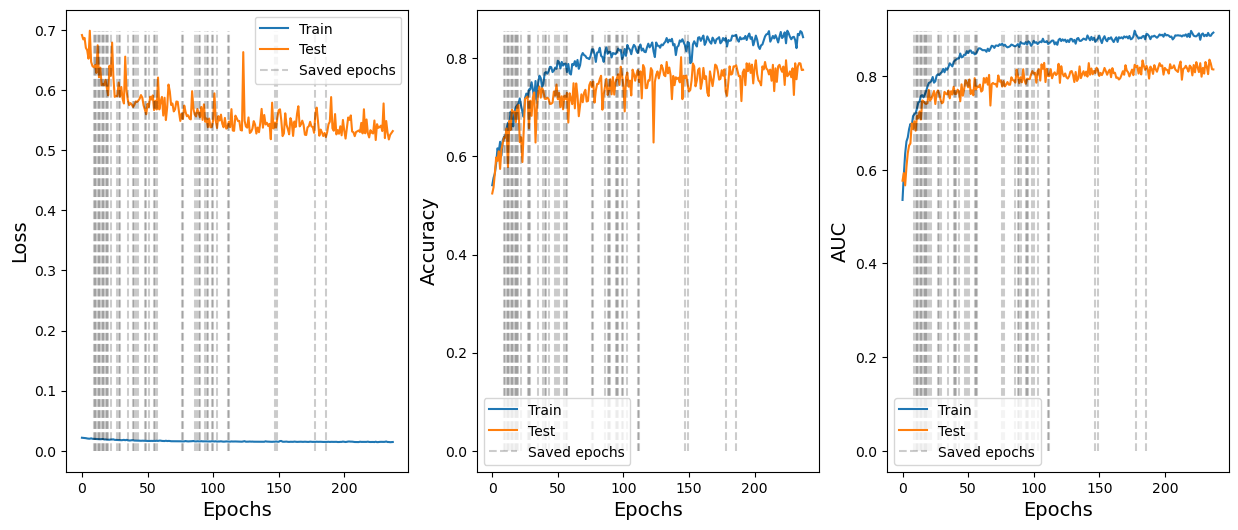

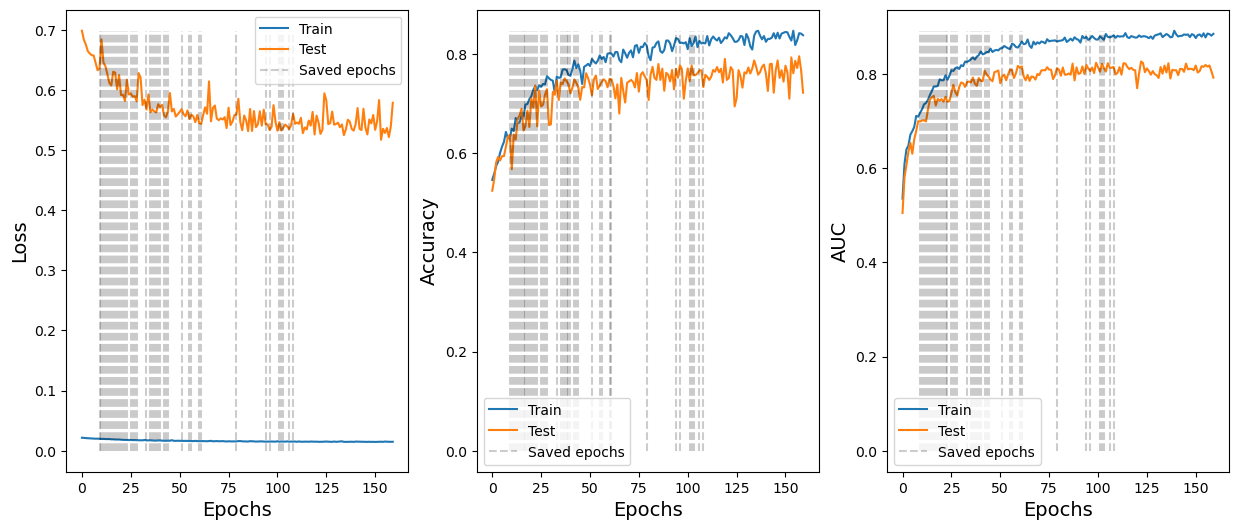

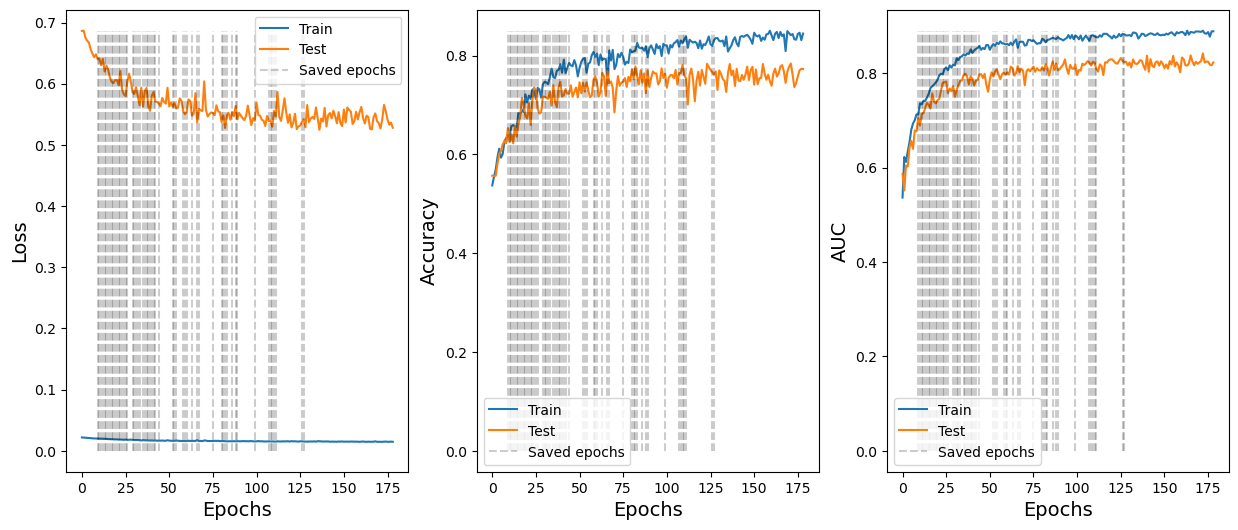

In [12]:
print("Model parameters saved at epochs:")
for i in range(0,5):
  with open(f'/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/models/gcn_models/{i}_128_300_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)
  print(loaded_dict["saved_epochs"][-1])

  loss_acc_auc_plots(loaded_dict)

In [13]:
"""
torch.manual_seed(42)
loaded_model = loaded_model.to(device)

train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(loaded_model, train_dataloader, test_dataloader, threshold=0.5)
print(round(train_auroc,4), round(test_auroc, 4))

print("Train Classification Report:")
display(train_classification_report)
print("Test Classification Report:")
display(test_classification_report)

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = ([False, True]))
cm_display_train.plot()

cm_display_test = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ([False, True]))
cm_display_test.plot()
"""

'\ntorch.manual_seed(42)\nloaded_model = loaded_model.to(device)\n\ntrain_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(loaded_model, train_dataloader, test_dataloader, threshold=0.5)\nprint(round(train_auroc,4), round(test_auroc, 4))\n\nprint("Train Classification Report:")\ndisplay(train_classification_report)\nprint("Test Classification Report:")\ndisplay(test_classification_report)\n\ncm_display_train = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = ([False, True]))\ncm_display_train.plot()\n\ncm_display_test = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ([False, True]))\ncm_display_test.plot()\n'

In [30]:
num_features = 30
num_hidden_channels = 128
num_out_channels = 2
heads = 4
num_layers = 3
edge_dim = 11
pool_method = global_mean_pool
use_edge_attr = True
nb_repeats = 5

gcn_model_skeleton = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
gat_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, False)
graphconv_model_skeleton = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
ginconv_model_skeleton = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)
gineconv_model_skeleton = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)
gate_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, True)

bace_gcn_models_path = bace_models_path / "gcn_models"
bace_gat_models_path = bace_models_path / "gat_models"
bace_graphconv_models_path = bace_models_path / "graphconv_models"
bace_ginconv_models_path = bace_models_path / "ginconv_models"
bace_gineconv_models_path = bace_models_path / "gineconv_models"
bace_gat_edge_models_path = bace_models_path / "gat_edge_models"

save_yes_no = False
auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(ginconv_model_skeleton, bace_ginconv_models_path, "_128_300_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=0.5)
print("Area under the curve metrics")
display(auroc_df)
print(f"Mean Train metrics from {nb_repeats} repeats")
display(mean_train_model_metrics)
print(f"Mean Test metrics from {nb_repeats} repeats")
display(mean_test_model_metrics)
print(f"Standard Deviation of train metrics from {nb_repeats} repeats") 
display(std_train_model_metrics)
print(f"Standard Deviation of test metrics from {nb_repeats} repeats")
display(std_test_model_metrics)

Area under the curve metrics


,Train,Test
0,0.928844,0.865051
1,0.016705,0.011333


Mean Train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.920561,0.797277,0.852728,661.000000
1.0,0.793159,0.915483,0.848476,549.000000
accuracy,0.850909,0.850909,0.850909,0.850909
macro avg,0.856860,0.856380,0.850602,1210.000000
weighted avg,0.862756,0.850909,0.850799,1210.000000


Mean Test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.828227,0.782609,0.803413,161.00000
1.0,0.770260,0.814085,0.790200,142.00000
accuracy,0.797360,0.797360,0.797360,0.79736
macro avg,0.799244,0.798347,0.796806,303.00000
weighted avg,0.801061,0.797360,0.797220,303.00000


Standard Deviation of train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.022251,0.066592,0.032317,0.000000
1.0,0.050714,0.031301,0.020443,0.000000
accuracy,0.026347,0.026347,0.026347,0.026347
macro avg,0.019737,0.022704,0.026159,0.000000
weighted avg,0.017414,0.026347,0.026715,0.000000


Standard Deviation of test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.021265,0.053611,0.019802,0.00000
1.0,0.036917,0.038443,0.006986,0.00000
accuracy,0.012480,0.012480,0.012480,0.01248
macro avg,0.011266,0.010190,0.011891,0.00000
weighted avg,0.010072,0.012480,0.012348,0.00000


In [33]:
mean_test_model_metrics["precision"].loc["1.0"]

0.7702601391288738

In [44]:
thresholds = [0.1,0.3,0.5, 0.7, 0.9]
precision_thresholds = []
recall_thresholds = []
for i in thresholds:
    auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(gcn_model_skeleton, bace_gcn_models_path, "_128_300_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=i)
    precision_thresholds.append(mean_test_model_metrics["precision"].loc["1.0"])
    recall_thresholds.append(mean_test_model_metrics["recall"].loc["1.0"])


In [45]:
precision_thresholds

[0.7341815297600933,
 0.748777653458304,
 0.7537684830799812,
 0.7633654236409505,
 0.7716148625024031]

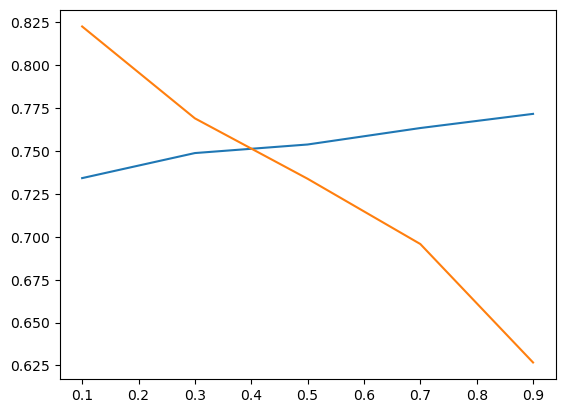

In [46]:
plt.plot(thresholds, precision_thresholds)
plt.plot(thresholds, recall_thresholds)

In [15]:
def plot_average_metrics(models_paths_list, metric_filenames, desired_metrics, bar_width, show_legend, fontsize, tick_labelsize):
    """
    Calculates and returns the average performance metrics for a list of GNN model architectures.

    This function loads performance metrics for multiple trained model instances from their respective directories,
    computes the mean and standard deviation of key metrics (AUROC, precision, recall), and plots the results. The
    function returns DataFrames containing the calculated metrics and their associated errors.

    Args:
        models_paths_list (List[Path]): A list of paths to the directories containing the trained model instances.
        metric_filenames (Dict[str, str]): A dictionary mapping metric names to their corresponding pickle file names.
                                           Expected keys are 'auroc', 'mean_train', 'mean_test', 'std_train', and 'std_test'.
        desired_metrics (List): A list of the metrics desired in the plot, to choose from: 

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]:
            - DataFrame containing the average performance metrics (AUROC, precision, recall) for the test dataset across models.
            - DataFrame containing the standard errors for the same metrics.

    Example Usage:
        metrics_filenames = {
            'auroc': "128_300_global_mean_pool_auroc_df.pkl",
            'mean_train': "128_300_global_mean_pool_mean_train_metrics.pkl",
            'mean_test': "128_300_global_mean_pool_mean_test_metrics.pkl",
            'std_train': "128_300_global_mean_pool_std_train_metrics.pkl",
            'std_test': "128_300_global_mean_pool_std_test_metrics.pkl"
        }

        models_metrics_df, models_metrics_error_df = plot_average_metrics(
            [bace_gcn_models_path, bace_gat_models_path, bace_graphconv_models_path, bace_ginconv_models_path, 
            bace_gat_edge_models_path, bace_gineconv_models_path],
            metrics_filenames,
            ["precision", "recall", "accuracy"]
        )
    """
    # Initialize empty DataFrames to store metrics and errors
    metrics_df = pd.DataFrame()
    metrics_error_df = pd.DataFrame()

    # Define the metrics to extract
    metric_names = ["auroc", "precision", "recall", "accuracy", "f1-score", "support"]

    # Name the bars
    models_names_dictionaries = {bace_gcn_models_path  : "GCN", bace_gat_models_path : "GAT", bace_graphconv_models_path : "Graph Conv", 
                                 bace_ginconv_models_path : "GIN Conv", 
                                 bace_gat_edge_models_path : "GAT Edge", 
                                 bace_gineconv_models_path : "GIN Edge"}

    # Loop through each model's path and compute metrics
    for i, model_path in enumerate(models_paths_list):
        model_path = Path(model_path)

        # Load data
        auroc_df = pd.read_pickle(model_path / metric_filenames['auroc'])
        mean_train_metrics = pd.read_pickle(model_path / metric_filenames['mean_train'])
        mean_test_metrics = pd.read_pickle(model_path / metric_filenames['mean_test'])
        std_train_metrics = pd.read_pickle(model_path / metric_filenames['std_train'])
        std_test_metrics = pd.read_pickle(model_path / metric_filenames['std_test'])

        # Extract metrics and errors
        metrics = {
            "test_auroc": auroc_df["Test"].iloc[0],
            "test_precision": mean_test_metrics["precision"].iloc[-1],
            "test_recall": mean_test_metrics["recall"].iloc[-1],
            "test_accuracy": mean_test_metrics["precision"].loc["accuracy"],
            "test_f1_score": mean_test_metrics["f1-score"].iloc[-1],
            "test_support": mean_test_metrics["support"].iloc[-1]
        }

        errors = {
            "test_auroc": auroc_df["Test"].iloc[1] / (5**0.5),
            "test_precision": std_test_metrics["precision"].iloc[-1] / (5**0.5),
            "test_recall": std_test_metrics["recall"].iloc[-1] / (5**0.5),
            "test_accuracy": std_test_metrics["precision"].loc["accuracy"],
            "test_f1_score": std_test_metrics["f1-score"].iloc[-1] / (5**0.5),
            "test_support": std_test_metrics["support"].iloc[-1] / (5**0.5)

        }

        # Store metrics and errors


        # model_name = models_paths_list[i].name  # or some other way to name models
        model_name = models_names_dictionaries[models_paths_list[i]]
        metrics_df[model_name] = metrics.values()
        metrics_error_df[model_name] = errors.values()

    # Set index to the metric names
    metrics_df.index = metric_names
    metrics_error_df.index = metric_names

    """
    print(metrics_df.index)
    if isinstance(desired_metrics, str):
       metrics_df.sort_values([desired_metrics], axis='index')
    """
    
    
     # x = np.arange(len(metrics_df.loc[desired_metrics]))*10
    # print(x)

    # Plot metrics
    ax = metrics_df.loc[desired_metrics].plot.bar(
        yerr=metrics_error_df.loc[desired_metrics],
        figsize=(8, 4),
        width=bar_width,
        capsize =2
    )

    # ax.set_xticks(x)
    # ax.set_xticklabels(metrics_df.loc[desired_metrics].index, rotation=0)
    
    ax.tick_params(axis='both', labelsize=tick_labelsize)
    ax.set_ylabel("Metric Value", fontsize = fontsize)
    ax.set_xlabel("Models", fontsize=fontsize)
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    if show_legend:
        ax.legend()
    plt.show()

    return metrics_df, metrics_error_df

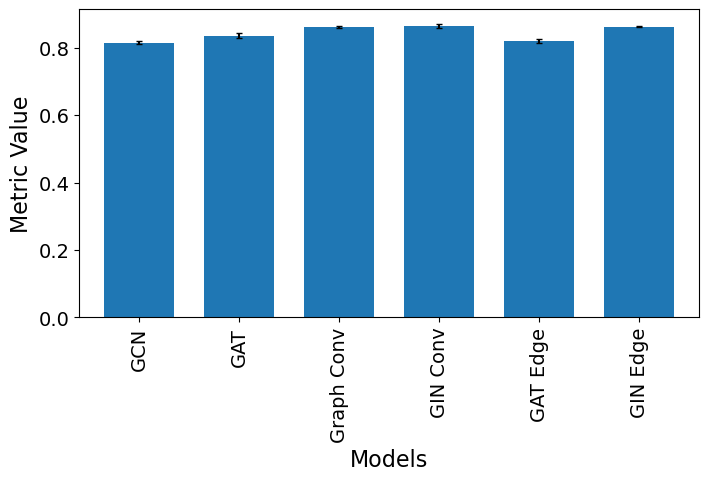

In [16]:
metrics_filenames = {
            'auroc': "128_300_global_mean_pool_auroc_df.pkl",
            'mean_train': "128_300_global_mean_pool_mean_train_metrics.pkl",
            'mean_test': "128_300_global_mean_pool_mean_test_metrics.pkl",
            'std_train': "128_300_global_mean_pool_std_train_metrics.pkl",
            'std_test': "128_300_global_mean_pool_std_test_metrics.pkl"
        }

models_metrics_df, models_metrics_error_df = plot_average_metrics(
    [bace_gcn_models_path, bace_gat_models_path, bace_graphconv_models_path, bace_ginconv_models_path, 
    bace_gat_edge_models_path, bace_gineconv_models_path],
    metrics_filenames, "auroc", bar_width = 0.7, show_legend = False, fontsize = 16, tick_labelsize = 14)

In [17]:
models_metrics_df

,GCN,GAT,Graph Conv,GIN Conv,GAT Edge,GIN Edge
auroc,0.815405,0.835579,0.862081,0.865051,0.820484,0.862462
precision,0.762401,0.787016,0.801411,0.801061,0.775684,0.786306
recall,0.761716,0.784818,0.800000,0.797360,0.775578,0.776898
accuracy,0.761716,0.784818,0.800000,0.797360,0.775578,0.776898
f1-score,0.761144,0.784651,0.799861,0.797220,0.775416,0.776282
support,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000


In [18]:
models_metrics_df.loc["precision"].sort_values(inplace=True)
models_metrics_df.loc["precision"]

GCN           0.762401
GAT           0.787016
Graph Conv    0.801411
GIN Conv      0.801061
GAT Edge      0.775684
GIN Edge      0.786306
Name: precision, dtype: float64

In [19]:
models_metrics_df.loc["precision"]

GCN           0.762401
GAT           0.787016
Graph Conv    0.801411
GIN Conv      0.801061
GAT Edge      0.775684
GIN Edge      0.786306
Name: precision, dtype: float64

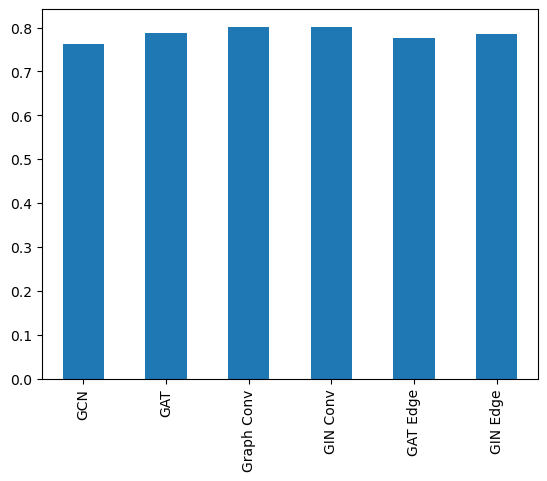

In [20]:
ax = models_metrics_df.loc["precision"].plot.bar(width=0.5)

In [21]:
models_metrics_df

,GCN,GAT,Graph Conv,GIN Conv,GAT Edge,GIN Edge
auroc,0.815405,0.835579,0.862081,0.865051,0.820484,0.862462
precision,0.762401,0.787016,0.801411,0.801061,0.775684,0.786306
recall,0.761716,0.784818,0.800000,0.797360,0.775578,0.776898
accuracy,0.761716,0.784818,0.800000,0.797360,0.775578,0.776898
f1-score,0.761144,0.784651,0.799861,0.797220,0.775416,0.776282
support,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000


In [22]:
models_metrics_df.loc["accuracy"]["gcn_models"]

KeyError: 'gcn_models'